# Overview

Here we will descrive the high-level tech stack of the machine learning system that we will build.

## Front-end and feedback

Developing in Javascript - yuk. Instead, use Python libraries [Gradio](https://www.gradio.app/) or [Streamlit](https://streamlit.io/). These libraries are designed for data applications. We also save ourselves from having to learn an entirely new tech stack as a Python developer.

Model feedback is sent to [Gantry](https://gantry.io/).

## Backend

The model backend accepts requests through a REST API. It's deployed in a Docker container, serverlessly in AWS Lambda. The choice to go serverless makes it effortless to scale up throughput by a couple of orders of magnitude. The Docker container is hosted in AWS Elastic Container Registry.

For more complex services, container orchestration becomes important. For this, the premium tool is Kubernetes (k8s).

## Training

Use a cloud GPU provider such as [Lambda Labs GPU Cloud](https://lambdalabs.com/service/gpu-cloud).

We develop the model using PyTorch. PyTorch is a lower-level library that provides autograd and features for making neural networks. It also accelerated gradient computations using the GPU. [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) is a higher-level framework that provides ??? (training loop?).

## Experiment and artifact tracking

MLFlow is an open source tool that tracks experiment results and hyperparameters, and artifacts (model checkpoints). Weights and Biases is a proprietary but hosted tool.

# Setup

We use [Conda](https://docs.conda.io/en/latest/) to manage Python environments.

We use [pip-tools](https://pypi.org/project/pip-tools/) to give us deterministic installations of Python packages. pip-tools compiles a list of requirements into a requirements file with exact versions, similar to `package.json` and `package-lock.json` in Javascript.

# PyTorch

## Tensors

A Tensor is PyTorch's array class. Numpy arrays can be passed into torch.Tensor as a constructor to create arrays.

In [2]:
import torch
import numpy as np

my_array = np.array([[1, 2], [3, 4]])

tensor = torch.Tensor(my_array)
tensor

tensor([[1., 2.],
        [3., 4.]])

A Tensor has `ndim` and `shape` attributes:

In [6]:
tensor.ndim

2


In [7]:
tensor.shape

torch.Size([2, 2])

and can be indexed as you would expect. Indexed Tensors always return a new Tensor.

In [8]:
tensor[:, 1:]

tensor([[2.],
        [4.]])

## Autograd

First, you need to tell PyTorch which tensor gradients to track:

In [3]:
a = torch.Tensor((3,))
b = torch.Tensor((2,))
a.requires_grad_()
b.requires_grad_()

tensor([2.], requires_grad=True)

Then write your function:

In [5]:
x = torch.Tensor((5,))
y = a * x + b
y

tensor([17.], grad_fn=<AddBackward0>)

And finally tell PyTorch which quantity to compute gradients with respect to:

In [7]:
y.backward()
print(a.grad)
print(b.grad)

tensor([5.])
tensor([1.])


For future calls, you need to zero the gradients.

In [11]:
a.grad.zero_()
b.grad.zero_()

tensor([0.])

## Datasets and Dataloaders

Within a _single split_ of out dataset (e.g. train or test), we have to align the x and y values. We can do this using `torch.utils.data.Dataset`.

In [26]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.x = torch.randn(100)
        self.y = torch.randn_like(self.x) + self.x
    
    def __getitem__(self, ii):
        return self.x[ii], self.y[ii]
    
    def __len__(self):
        return len(self.x)

In [27]:
mydataset = MyDataset()

In [28]:
len(mydataset)

100

In [29]:
len(torch.randn(100))

100

In [31]:
mydataset[0]

(tensor(-1.2057), tensor(-1.8518))

In [32]:
import matplotlib.pyplot as plt

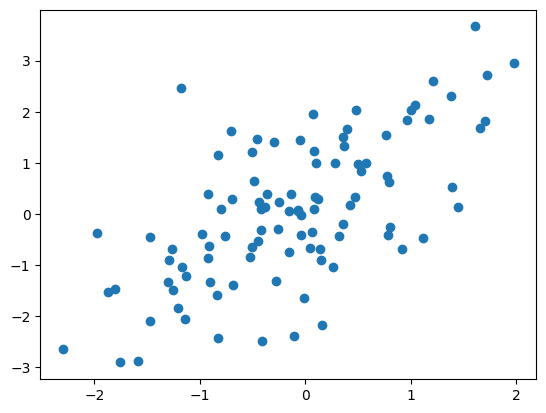

In [46]:
x, y = mydataset[:]
plt.scatter(x, y)
plt.show()

We can make use of Dataloaders to automatically batch up our data.

In [49]:
from torch.utils.data import DataLoader

my_dataloader = DataLoader(mydataset, batch_size=10)

In [52]:
next(iter(my_dataloader))

[tensor([-1.2057, -0.9754,  0.8051,  1.7271,  1.7104, -0.7013,  0.4768,  0.7633,
         -0.0388, -1.1386]),
 tensor([-1.8518, -0.4042, -0.2619,  2.7286,  1.8250,  1.6149,  0.3306,  1.5434,
         -0.4194, -2.0667])]

## More data organisation with Data Modules

For proper organisation, we can create a data module class which sets up train and validation splits, creates `Datasets` for them, and wrap them up in `DataLoader`s.

In [56]:
class MyDataModule():
    def __init__(self, dir, bs=32):
        self.dir = dir
        self.bs = bs
    
    def prepare_data(self):
        # once-per-machine set up for downloading data
        pass
    
    def setup(self):
        # loads data into memory and creates Datasets
        this.train_dataset = None
        this.val_dataset = None
    
    def train_dataloader(self):
        return DataLoader(this.train_dataset, batch_size=bs, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(this.val_dataset, batch_size=bs, shuffle=True)

# Modules

Modules in PyTorch represent functions with parameters where you want to keep track of gradients.

A `Parameter` assigned as an attribute will be listed in the object's `.parameters()` method.

Modules can be assigned as attributes of other modules. In this case, parameters are recursively added to their parent's module.

Gradients still need to be manually calculated and updated, but this is much easier now by looping over `module.parameters()` or passing that to an optimiser.

# PyTorch Lightning

PyTorch Lightning helps organise your code and data.

## The `pl.LightningModule`

The LightningModule is a subclass of a PyTorch Module. It contains adds support for `.training_step()`, `.validation_step()` and `.test_step()` methods, which run on training, validation and test steps. These methods are passed the batch and batch id.

The LightningModule also adds support for a `.configure_optimizers()` method, where you can set up and return an optimizer pointing at the model's parameters.

## The `pl.Trainer`

The pl.Trainer, when instantiated, takes arguments related to the training loop such as min and max epochs, min and max steps, and gpu usage:

In [60]:
import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=20, gpus=int(torch.cuda.is_available()))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The `.fit` method of `trainer` takes the model and dataloader we want to use:

In [ ]:
trainer.fit(model=model, train_dataloaders=tdl)

The `pl.Trainer` class is highly customisable. Here are just some of the flags available:
    
* `auto_lr_find`: will make `trainer.tune()` run a learning rate find
* `auto_scale_batch_size`: will find the largest batch size that can fit in memory and store in `self.batch_size` in the LightningModule
* `callbacks`: list of callbacks
* `enable_checkpointing`: enable checkpointing
* `fast_dev_run`: will run `n` or 1 (if set to `True`) batches as a test to find bugs
* `gpus`: number of GPUs to train on (if int) or which GPUs to use (list or str)
* `logger`: Logger for experiment tracking. A `True` value uses the default `TensorboardLogger`
* `enable_progress_bar`: whether to enable the progress bar
* `profiler`: to profile individual steps in the training process to find bottlenecks
* `max_epochs`, `min_epochs`, `max_steps`, `min_steps`, `max_time`: control training length
* `detect_anomaly`: enable anomaly detection in the autograd engine, for example if any of the metrics are NaN or inf
* `val_check_interval`: how often to run the validation loop. Pass a float in [0.0, 1.0] to run at a fraction of each epoch, or an int to run every n batches
* `enable_model_summary`: prints a model summary at the start of training
* `num_sanity_val_steps`: perform a dummy validation before the first training epoch. This prevents bugs with validation only being found after the first epoch, which could be hours. Set to 0 to disable

## The `pl.LightningDataModule`

The `LightningDataModule` is a standard form of the data modules above, following a similar format. PyTorch will automatically run `.prepare_data()` and `.setup()` once per machine, and on each GPU respectively. `LightningDataModules` can also play nicely with `pl.Trainer`, for example with the `auto_scale_batch_size` flag.

```
    Example::

        class MyDataModule(LightningDataModule):
            def __init__(self):
                super().__init__()
            def prepare_data(self):
                # download, split, etc...
                # only called on 1 GPU/TPU in distributed
            def setup(self, stage):
                # make assignments here (val/train/test split)
                # called on every process in DDP
            def train_dataloader(self):
                train_split = Dataset(...)
                return DataLoader(train_split)
            def val_dataloader(self):
                val_split = Dataset(...)
                return DataLoader(val_split)
            def test_dataloader(self):
                test_split = Dataset(...)
                return DataLoader(test_split)
            def teardown(self):
                # clean up after fit or test
                # called on every process in DDP
```

## `pl.Callback`

A class that implements methods such as `on_train_epoch_start`, which, you guessed it, runs a callback at the appropriate time during the training loop.

## `torchmetrics`

`torchmetrics` is a very useful library for calculating metrics.